In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [15]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

In [16]:
ROOT_DIR = "/kaggle/input/sign-language-mnist"

train_df = pd.read_csv(os.path.join(ROOT_DIR, "sign_mnist_train", "sign_mnist_train.csv"))
test_df = pd.read_csv(os.path.join(ROOT_DIR, "sign_mnist_test", "sign_mnist_test.csv"))
train_df.head

<bound method NDFrame.head of        label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0          3     107     118     127     134     139     143     146     150   
1          6     155     157     156     156     156     157     156     158   
2          2     187     188     188     187     187     186     187     188   
3          2     211     211     212     212     211     210     211     210   
4         13     164     167     170     172     176     179     180     184   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
27450     13     189     189     190     190     192     193     193     193   
27451     23     151     154     157     158     160     161     163     164   
27452     18     174     174     174     174     174     175     175     174   
27453     17     177     181     184     185     187     189     190     191   
27454     23     179     180     180     180     182     181     182     183   

       pi

In [37]:
def process_dataset(dataset):
    y_train_df = dataset[dataset.columns[0]]
    X_train_df = dataset.drop(columns=dataset.columns[0])
    X_train_np = np.reshape(X_train_df.values, (-1, 28, 28))
    X_train_np = np.expand_dims(X_train_np, axis=-1) / 255
    
    return X_train_np, y_train_df.values
    

In [38]:
x_train_df, y_train_df = process_dataset(train_df)
x_train_df.shape

(27455, 28, 28, 1)

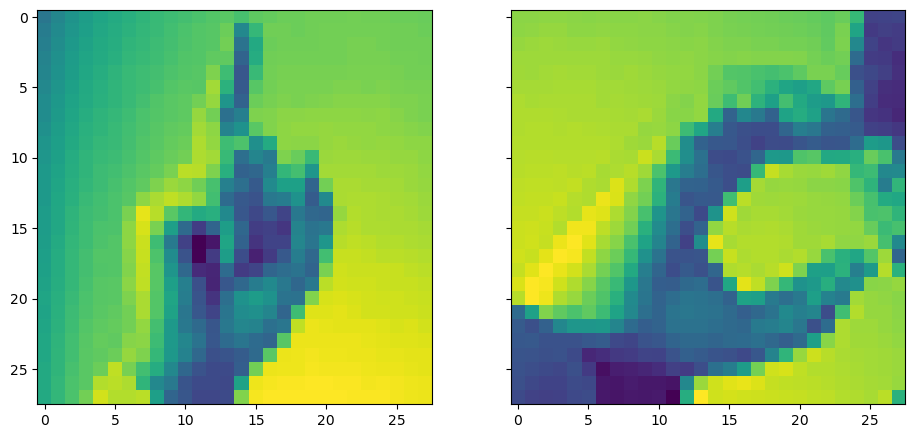

In [55]:
_scale = 0.8
fig, arr = plt.subplots(1, 2, sharey=True, figsize=(14*_scale,10*_scale))
arr[0].imshow(x_train_df[0])
arr[1].imshow(x_train_df[3])

In [63]:
early_stoping = callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

class LearningRateMode(tf.keras.callbacks.Callback):
    def __init__(self, lr, sigma):
        self.lr = lr
        self.sigma = sigma
    
    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.lr/(1 + self.sigma*epoch)
        self.model.optimizer.lr.assign(new_lr)
        if 'lr' not in self.model.history.history:
            self.model.history.history['lr'] = []
        self.model.history.history['lr'].append(new_lr)
        print(f"\nUpdated lr to {new_lr}")

learningRateMod = LearningRateMode(0.01, 0.8)

In [70]:
import tensorflow.keras.layers as tfl

model = tf.keras.models.Sequential([
    tfl.Conv2D(64, kernel_size=3, padding="same", activation="relu", input_shape=(28, 28, 1), kernel_initializer="he_normal"),
    tfl.MaxPooling2D(pool_size=(2,2)),
    tfl.Conv2D(32, kernel_size=3, padding="same", activation="relu", kernel_initializer="he_normal"),
    tfl.MaxPooling2D(pool_size=(2,2)),
    tfl.Dropout(0.2),
    tfl.Flatten(),
    tfl.Dense(32, activation="relu"),
    tfl.Dense(26, activation="softmax")
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [71]:
history = model.fit(x_train_df, y_train_df, epochs=20, validation_data=process_dataset(test_df), callbacks=[early_stoping, learningRateMod])

Epoch 1/20
857/858 [============================>.] - ETA: 0s - loss: 1.2582 - accuracy: 0.6144
Updated lr to 0.01
858/858 [==============================] - 30s 34ms/step - loss: 1.2572 - accuracy: 0.6146 - val_loss: 0.5462 - val_accuracy: 0.8143
Epoch 2/20
858/858 [==============================] - ETA: 0s - loss: 0.3327 - accuracy: 0.8897
Updated lr to 0.005555555555555556
858/858 [==============================] - 28s 33ms/step - loss: 0.3327 - accuracy: 0.8897 - val_loss: 0.5563 - val_accuracy: 0.8613
Epoch 3/20
857/858 [============================>.] - ETA: 0s - loss: 0.0521 - accuracy: 0.9831
Updated lr to 0.003846153846153846
858/858 [==============================] - 29s 34ms/step - loss: 0.0520 - accuracy: 0.9831 - val_loss: 0.4731 - val_accuracy: 0.8925
Epoch 4/20
858/858 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9917
Updated lr to 0.0029411764705882353
858/858 [==============================] - 29s 34ms/step - loss: 0.0244 - accuracy: 0.9917 -

In [ ]:
learning_rate = history.history["lr"]

plt.plot(learning_rate, history.history["loss"])